<!-- Add CSS Styles. Content starts in the next cell. -->

<!-- Boxes that stand out to catch the readers attention. -->

<style>
.info {
  padding: 20px;
  background-color: #139ed6;
  color: white;
  margin-bottom: 15px;
}

.info:before {
 content: "📝";
}

.warn {
  padding: 20px;
  background-color: #d11414;
  color: white;
  margin-bottom: 15px;
}

.warn:before {
 content: "⚠️";
}
</style>

# Predicting Future Sales

This notebook contains the process of the data for my submission
to the Kaggle competition ["Predicting Future Sales"](https://www.kaggle.com/c/competitive-data-science-predict-future-sales).

A setup guide for the runtime environment can be found in the projects
[README](./README.adoc) file.

<!-- Table of contents -->

<!-- TODO: add TOC -->

## Prerequisites

### Imports

In [1]:
# Basic packages
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced features
from itertools import product  # make a cross product
from datetime import datetime
from calendar import monthrange  # get the amount of days in a given YYYY-MM

# Machine learning tools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# My packages
import src.plotting.Defaults
from src.datacleaning.ConvertingDateValues import date_to_month, date_to_iso8601, iso8601_format
from src.util.FunctionExecTime import time_runtime
from src.util.ParseDataframe import get_item_cnt_metric
from src.util.ListActions import cl

### Set package options

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

%matplotlib inline
# set the default marker style for all plots
src.plotting.Defaults.set_defaults()

### Import data

In [3]:
default_converters = {
    'date_block_num': eval,
    'shop_id': eval,
    'item_id': eval,
    'item_price': eval,
    'item_cnt_day': eval,
}

primary_columns = ['date_block_num', 'shop_id', 'item_id']

In [4]:
# Metadata packages
items = pd.read_csv('data/info/items.csv')
shops = pd.read_csv('data/info/shops.csv')
cats = pd.read_csv('data/info/item_categories.csv')

# Train and test data
train = pd.read_csv('data/technical/sales_train.csv',
                    parse_dates=['date'],
                    dayfirst=True,
                    converters=default_converters,
                    )
test  = pd.read_csv('data/technical/test.csv',
                    converters=default_converters,
                    ).set_index('ID')

### Data formatting

In [5]:
# contains the raw train with months only
train_in_months = train.copy()
train_in_months = time_runtime(date_to_month, train_in_months)

Runtime of function "date_to_month": 12s


Map the date to its index for later use

In [6]:
def generate_date_mapper():
    """
    Map the date in YYYY-MM format to the given `date_block_num` table.
    """
    date_block_num_set = set(train_in_months['date_block_num'])
    date_set = set(train_in_months['date'])

    date_block_num_distinct = list(date_block_num_set)
    date_block_num_distinct.sort()
    date_distinct = list(date_set)
    date_distinct.sort()

    mapper = {}
    for i in date_block_num_distinct.__iter__():
        mapper.update({date_block_num_distinct[i]: date_distinct[i]})

    # append the month which is to be predicted
    mapper.update({34: '2015-11'})

    return mapper


date_mapper = generate_date_mapper()

def get_month_from_index(i):
    """
    Returns the month in 'YYYY-MM' format of a given `date_block_num` index.
    """
    return date_mapper.get(i)

def get_index_of_month(month):
    """
    Returns the index in the `date_block_num` table of a given month
    (in YYYY-MM format).
    """
    return list(date_mapper.keys())[list(date_mapper.values()).index(month)]

<br><br><br><br><br><br><br><br><br><br>

## Exploratory Data Analysis

### Clean features

First, verify that there are no incomplete entries in the dataset:

In [7]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### View monthly sales

In [8]:
def view_all_sales():
    # create a new data frame with the relevant columns.
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day'])
    df.set_index('date', inplace=True)

    # sum the values to get a monthly overview
    df = df.groupby(['date']).sum()

    # rename the column to match new output
    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

    return df

all_sales = time_runtime(view_all_sales)

Runtime of function "view_all_sales": 185ms


<AxesSubplot:xlabel='date'>

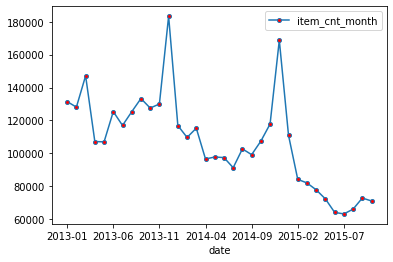

In [9]:
all_sales.plot()

<div class="info">
    We can observe a strong seasonality with spiking end of year sales.
    <br>
    This is particularily noteworthy as the month to predict in question is
    going to be the month of november.
    <br><br>
    Additionally, the trend seems to be going downwards over time.
</div>

### View monthly revenue

In [10]:
def compute_revenue(df):
    item_cnt_metric = get_item_cnt_metric(df)
    df['revenue'] = df.apply(lambda x: x[item_cnt_metric] * x['item_price'], axis=1)
    return df

def check_revenue():
    # pick the relevant columns
    df = pd.DataFrame(train_in_months, columns=['date', 'item_cnt_day', 'item_price'])
    # calculate the revenue
    df = compute_revenue(df)
    # drop no longer needed columns
    df.drop(['item_cnt_day', 'item_price'], axis=1, inplace=True)

    # set the index
    df.set_index('date', inplace=True)
    # and regroup the monthly revenue
    return df.groupby(['date']).sum()

revenue = time_runtime(check_revenue)

Runtime of function "check_revenue": 19s


<AxesSubplot:xlabel='date'>

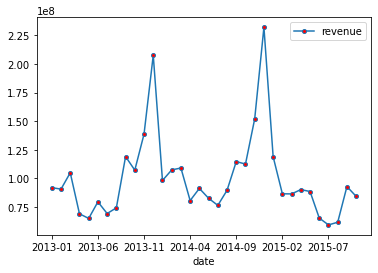

In [11]:
revenue.plot()

<div class="info">
    Fortunately, the revenue is closely correlated to the total sales as
    excpected.
</div>

### Inspect `item_cnt_day`

<AxesSubplot:xlabel='item_cnt_day'>

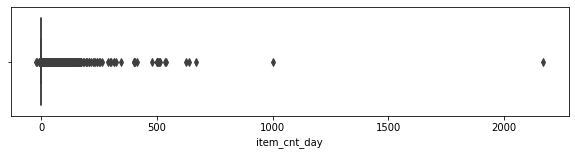

In [12]:
plt.figure(figsize=(10,2))
sns.boxplot(x=train_in_months.item_cnt_day)

<div class="info">
    Two outliers can be observed. This will have to be examined further
    down the line.
</div>

### Inspect `item_price`

<AxesSubplot:xlabel='item_price'>

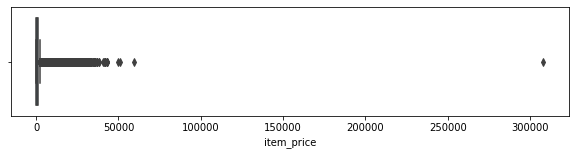

In [13]:
plt.figure(figsize=(10,2))
sns.boxplot(x=train_in_months.item_price)

<div class="info">
    One outlier can be observed. This will have to be examined further
    down the line.
</div>

### Inspect `item_id`

In [14]:
def inspect_total_sales_per_item_cat():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'item_id'])
    df = df.set_index('item_id', drop=True).join(items.set_index('item_id'))
    df.drop(['item_name'], axis=1, inplace=True)
    df.set_index(['item_category_id'], inplace=True)
    df = df.groupby(['item_category_id']).sum()
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df


sales_per_item_cat = time_runtime(inspect_total_sales_per_item_cat)

Runtime of function "inspect_total_sales_per_item_cat": 278ms


Text(0, 0.5, 'Total item category sales')

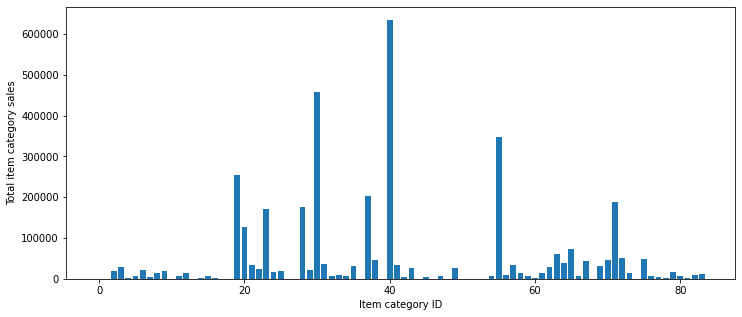

In [15]:
plt.figure(figsize=(12,5))
plt.bar(sales_per_item_cat.index, sales_per_item_cat['item_cnt_total'])
plt.xlabel("Item category ID")
plt.ylabel("Total item category sales")

#### Inspect outliers

Obvious top-performers are found. Let's find out what the category corresponds
to as well as verify that there are no categories without any sale records.

In [16]:
top_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] > 200_000]
top_performing_item_categories = top_performing_item_categories.join(cats, on='item_category_id', how='inner')
top_performing_item_categories.head(top_performing_item_categories.size)

,item_cnt_total,item_category_name,item_category_id
item_category_id,,,
19,254887.0,Игры - PS3,19
30,456540.0,Игры PC - Стандартные издания,30
37,203284.0,Кино - Blu-Ray,37
40,634171.0,Кино - DVD,40
55,348591.0,Музыка - CD локального производства,55


Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))

| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| Игры - PS3                            | Games - PS3                           |
| Игры PC - Стандартные издания	        | PC Games - Standard Editions          |
| Кино - Blu-Ray	                    | Movie - Blu-Ray                       |
| Кино - DVD	                        | Movies - DVD                          |
| Музыка - CD локального производства   | Music - locally produced CD           |

In [17]:
low_performing_item_categories = sales_per_item_cat[sales_per_item_cat['item_cnt_total'] < 10]
low_performing_item_categories = low_performing_item_categories.join(cats, on='item_category_id', how='inner')
low_performing_item_categories.head(low_performing_item_categories.size)

,item_cnt_total,item_category_name,item_category_id
item_category_id,,,
0,3.0,PC - Гарнитуры/Наушники,0
1,2.0,Аксессуары - PS2,1
10,1.0,Игровые консоли - PS2,10
27,8.0,Игры MAC - Цифра,27
48,6.0,Книги - Компьютерная литература,48
50,3.0,Книги - Открытки,50
51,1.0,Книги - Познавательная литература,51
52,3.0,Книги - Путеводители,52
53,3.0,Книги - Художественная литература,53


Let's have a look at the translation ([using Google Translate](https://translate.google.com/?sl=ru&tl=en&op=translate))

| Russian                               | Translation                           |
| ------------------------------------- | ------------------------------------- |
| PC - Гарнитуры/Наушники	            | PC - Headsets / Headphones            |
| Аксессуары - PS2	                    | Accessories - PS2                     |
| Игровые консоли - PS2	                | Game consoles - PS2                   |
| Игры MAC - Цифра	                    | MAC Games - Number                    |
| Книги - Компьютерная литература	    | Books - Computer Literature           |
| Книги - Открытки	                    | Books - Postcards                     |
| Книги - Познавательная литература     | Books - Educational literature        |
| Книги - Путеводители                  | Books - Guides                        |
| Книги - Художественная литература     | Books - Fiction                       |

Books seem to be in very low demand. Let's find out if there are any other
categories containing books.

In [18]:
other_book_cats = cats[cats['item_category_name'].str.contains("Книги")]
other_book_cats.head(other_book_cats.size)

,item_category_name,item_category_id
42,"Книги - Артбуки, энциклопедии",42
43,Книги - Аудиокниги,43
44,Книги - Аудиокниги (Цифра),44
45,Книги - Аудиокниги 1С,45
46,Книги - Бизнес литература,46
47,"Книги - Комиксы, манга",47
48,Книги - Компьютерная литература,48
49,Книги - Методические материалы 1С,49
50,Книги - Открытки,50
51,Книги - Познавательная литература,51


In [19]:
book_sales = sales_per_item_cat[sales_per_item_cat.index >= 42]
book_sales = book_sales[book_sales.index <= 54]
book_sales.head(book_sales.size)

,item_cnt_total
item_category_id,
42,3955.0
43,26595.0
44,252.0
45,5236.0
46,15.0
47,6876.0
48,6.0
49,26490.0
50,3.0


Inspect the average amount of books sold, which is expected to be well
below average.

The most selling book subcategories within the book section are namely
category 43 with "Audiobooks" (Книги - Аудиокниги) and category 49
with "methodical materials" from the in-store brand from [1C](https://1c.ru/eng/title.htm).
(Книги - Методические материалы 1С)

In [20]:
# average amount of sold books per category
int(book_sales['item_cnt_total'].sum() / book_sales.size)

5872

#### Inspect overall average of sales of each item category

In [21]:
# overall average of sold items per item category
int(sales_per_item_cat['item_cnt_total'].sum() / sales_per_item_cat.size)

43431

#### Conclusion

<div class="info">
    We can see that for this "software store", media seems to be of
    particularly popular demand.
    <br>
    The categories containing various subcategories of books is well
    below the average demand in a store.
    <br>
    Potential features could be extracted from this information.
</div>

### Inspect `shop_id`

In [22]:
def inspect_total_sales_per_shop():
    df = pd.DataFrame(train_in_months, columns=['item_cnt_day', 'shop_id'])
    df.set_index(['shop_id'], inplace=True)
    df.rename(columns = {'item_cnt_day':'item_cnt_total'}, inplace = True)

    return df.groupby(['shop_id']).sum()

sales_per_shop = time_runtime(inspect_total_sales_per_shop)

Runtime of function "inspect_total_sales_per_shop": 40ms


Text(0, 0.5, 'Total shop sales')

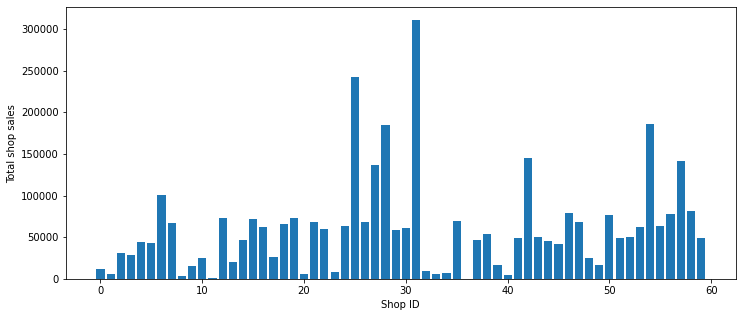

In [23]:
plt.figure(figsize=(12,5))
plt.bar(sales_per_shop.index, sales_per_shop['item_cnt_total'])
plt.xlabel("Shop ID")
plt.ylabel("Total shop sales")

#### Inspect outliers

Shop Nr. 36 appears to be non-existent. Let's verify that.

In [24]:
int(sales_per_shop.iloc[36]['item_cnt_total'])

330

#### Inspect overall average of sales per shop

In [25]:
int(sales_per_shop['item_cnt_total'].sum() / sales_per_shop.size)

60803

#### Conclusion

<div class="info">
    We verified that each and every shop has a positive sales record.
    <br>
    The average value of 60k sales per shop in total can be confirmed in the
    bar diagramm showing the distribution: there are about as many shop's with
    under-average performance as there are shops with an exceptionally
    high record.
    <br>
    The location of the shops might be of additional interest.
    <br>
    Shop Nr. 55 is the Online Store of the company.
    <br>
    Shop Nr. 20 to 32 are all located in the capital city of Moscow
</div>

### Inspect the time series

In [26]:
train_in_iso8601 = train.copy()
train_in_iso8601 = time_runtime(date_to_iso8601, train_in_iso8601)

Runtime of function "date_to_iso8601": 12s


In [27]:
all_dates = set()

def put_all_days_in_set():
    for index, row in train_in_iso8601.iterrows():
        date = row['date']  # access the row
        date = datetime.strptime(date, '%Y-%m-%d')  # convert to datetime format
        date_as_int = date.toordinal()  # convert to ordinal format for date arithmetic
        all_dates.add((date_as_int, date))  # add to set

time_runtime(put_all_days_in_set)

Runtime of function "put_all_days_in_set": 1min & 51s


In [28]:
# transform the set to a list and sort it
all_dates = list(all_dates)
all_dates.sort()

In [29]:
counter_entries_in_all_dates = len(all_dates)
anomalies_in_date_series = set()

def check_for_interruptions():
    for i in range(counter_entries_in_all_dates):


        if i != (counter_entries_in_all_dates - 1):
            ordinal_this_date = all_dates[i][0]
            ordinal_successor_date = all_dates[i+1][0]

            if ordinal_this_date + 1 != ordinal_successor_date:
                print(f"{i}, {all_dates[i]}")
                anomalies_in_date_series.add(i)

time_runtime(check_for_interruptions)

Runtime of function "check_for_interruptions": 176ns


In [30]:
all_dates[-1]

(735902, datetime.datetime(2015, 10, 31, 0, 0))

<div class="info">
    No breaks in between dates of sale made.
    <br>
    The last record is indeed on the last day of October.
</div>

### Inspect the correlation between features

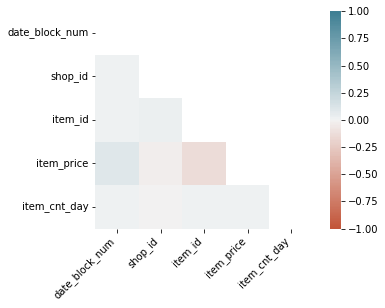

In [31]:
def draw_correlation_matrix():
    corr = train.corr()

    # Generate a mask to hide duplicate values
    mask = np.triu(np.ones_like(corr, dtype=bool))

    ax = sns.heatmap(
        corr,
        mask=mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    # format the axis output
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );  # the ';' suppresses the output


draw_correlation_matrix()

<div class="info">
    We observe no strong correlation between the features at this point.
    The only slight hint lies between the correlation between the <tt>item_price</tt> and the date
    of the sale in <tt>date_block_num</tt>.
</div>

### Results of the in-depth EDA.

Final observations from the [in-depth EDA](./In_Depth_EDA.ipynb).

<div class="info">
    The following datapoints from an item categories and shops perspective are
    indicating an unpredictable outcome that needs to be accounted for in the
    models.
    <br><br>
    <b><u>Item categories:</u></b>
    <br>
    The following categories have a mere one to two entries:
    <br>
    1, 10, 50, 51, 52
    <br>
    The following categories suggest very unpredictable results:
    <br>
    0, 18, 27, 36, 48, 53, 80
    <br>
    The following categories show a clear downward trend:
    <br>
    13, 21, 30, 40, 43, 45, 59, 62, 66, 77, 81, 82
    <br><br>
    <b><u>Shops:</u></b>
    <br>
    The following shops have a mere one to two entries:
    <br>
    0, 1, 11, 20, 36
    <br>
    The following shops suggest very unpredictable results:
    <br>
    8, 9, 23, 32, 33
    <br>
    The decline in sales per shop is not as striking as the one on a category
    basis. This indicates that there are items going out of fashion while the
    shops are able to secure their relevancy in the market with an adapting
    supply.
</div>

### Inspect the submission set

The template for which features are to be predicted is included with the
challenge. As the dataset is highly volatile with selected shops having no sales
in given categories on a given month.
Let's analyse which items are relevant and included in previous data. We suspect
that there could be new items in the submission which have no record in
previous data at all.

#### Find newly appearing items

In [32]:
test_item_id_set = set(test.item_id)
train_item_id_set = set(train.item_id)
item_id_sets_intersection = test_item_id_set - test_item_id_set.intersection(train_item_id_set)
len(item_id_sets_intersection)

363

#### Inspect the total of distinct test items

In [33]:
count_distinct_items = len(test_item_id_set)
count_distinct_items

5100

#### Inspect the total size of the test set

In [34]:
test_length = len(test)
test_length

214200

#### Find relation between items and shops

In [35]:
test_length / count_distinct_items

42.0

#### Approximate the existing coverage of entries

With having 5100 items from 42 shops inspected, while having a record of 33
months of data present. We can estimate the coverage of existing entries for
a given datapoint.

In [36]:
train_length = len(train)
coverage = train_length / (test_length * 33)
coverage

0.41533670033670034

<div class="info">
    As we can see, there are a total of 5100 distinct items in the test set
    which is to be predicted. The total size of the test data is 214.200, the
    exact size of the submission sample.
    <br>
    The relationship between the total length and the distinct items conducts
    that exactly 42 distinct shops are going to be predicted.
    <br>
    363 items are new in the test set which have
    no record in any of the train data.
    <br>
    The newly added data will have to be accounted for and added to the train
    set by adding datapoints which indicate the model that this item has not
    been sold before.
    <br>
    Additionally, we observe that the coverage of dedicated entry point for a
    given item is at best 42%. The high volatility and constantly changing
    product range indicates that it is likely even less. It will be a good idea
    to fill the train set with explicit zero sale entries for the items.
</div>

<br><br><br><br><br><br><br><br><br><br>

## Feature engineering

Begin by allocating a final dataframe where all the new features are going to
be stored.

In [63]:
train_fe = train_in_months.copy()

### Batch feature engineering

Create a function which makes sure to apply the same operations on the train
and testing dataset.

In [64]:
def apply_feature_engineering(df):
    """
    Calls all functions to apply the feature engineering equally on the
    train and test dataset.
    """
    df = time_runtime(regroup_monthly_sales, df)
    df = time_runtime(create_zero_sales, df)
    df = time_runtime(fill_missing_data, df)
    df = time_runtime(apply_shop_duplicates, df)
    df = time_runtime(apply_shop_location, df)
    df = time_runtime(apply_revenue_feature, df)
    df = time_runtime(apply_label_lag_feature, df)
    df = time_runtime(add_detailed_lag_features, df)
    df = time_runtime(add_month_feature, df)
    df = time_runtime(add_days_in_month, df)
    df = time_runtime(add_average_price, df)
    return df

Create a static list to store the categorical columns to encode these later on.

In [65]:
encode_categorical_features = set()

### Throw away the daily sales record

In [66]:
def regroup_monthly_sales(df):

    cols = ['date_block_num','shop_id','item_id']

    df_item_price = df.groupby(cols).agg({'item_price': ['mean']})
    df = df.groupby(cols).agg({'item_cnt_day': ['sum']})

    df = pd.merge(df, df_item_price, how="inner", on=cols)

    df.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
    # clip it according to the description of the competition
    df['item_cnt_month'] = df['item_cnt_month'].clip(0, 20)
    df.reset_index(inplace=True)

    df = add_dateblocknum_to_date(df)

    # remove the multi-index create by the `agg` function
    df.columns = df.columns.droplevel(1)

    return df


def add_dateblocknum_to_date(df):
    df['date'] = df['date_block_num'].apply(lambda x: get_month_from_index(x))
    return df

### Fill the train data

#### Add the missing data

Populate the train data with non-existing sales to indicate that the item
is accounted for but has not been sold in a given month.

In [67]:
def merge_remaining_data_back(df, df_cp, cols):
    """
    Merge the cross-product dataframe with zero-sales and drop the duplicated
    values at the end.
    """
    df = pd.merge(df, df_cp, on=cols, how="outer")
    return df.drop_duplicates(cols)


def create_zero_sales(df):
    """
    Create a cross-product between the date_block_num, unique shop_id's and
    unique item_id's. This will allow us to indicate sales that have never
    happened to allow for a more even distribution of the sales.
    """
    df_cross_product = []
    relevant_cols = ['date_block_num', 'shop_id', 'item_id']
    for i in range(34):
        sales = df[df.date_block_num == i]
        df_cross_product.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())),
                                         dtype='int16'))

    df_cross_product = pd.DataFrame(np.vstack(df_cross_product), columns=relevant_cols)
    df_cross_product['date_block_num'] = df_cross_product['date_block_num'].astype(np.int8)
    df_cross_product['shop_id'] = df_cross_product['shop_id'].astype(np.int8)
    df_cross_product['item_id'] = df_cross_product['item_id'].astype(np.int16)
    df_cross_product.sort_values(relevant_cols,inplace=True)

    df_cross_product = merge_remaining_data_back(df, df_cross_product, relevant_cols)

    return df_cross_product


#### Fill the missing data

In [68]:
def fill_with_itemprice_mean(df):

    df_item_price_avg = df.groupby('item_id').agg({'item_price': ['mean']})
    df_item_price_avg.columns = df_item_price_avg.columns.droplevel(1)

    # transform to hashmap to make quicker searches
    price_avg_dict = df_item_price_avg.to_dict()
    price_avg_dict = price_avg_dict.get('item_price')

    df['item_price'] = df.apply(
        lambda row: price_avg_dict.get(row['item_id'])
        if np.isnan(row['item_price']) else row['item_price'],
        axis=1
    )

    return df

def fill_zero_sales(df):
    df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
    return df

def fill_missing_data(df):
    df = add_dateblocknum_to_date(df)
    df = fill_zero_sales(df)
    df = fill_with_itemprice_mean(df)
    return df

### Shops

#### Duplicated shops

When inspecting their names, A few shops appear to be duplicates of each other.
Namely:

| Shop name                         | Shop ID | Shop name                   | Shop ID |
| -------------------------         | ------- | --------------------------- | ------- |
| !Якутск Орджоникидзе, 56 фран     | 0       | Якутск Орджоникидзе, 56     | 57      |
| !Якутск ТЦ "Центральный" фран     | 1       | Якутск ТЦ "Центральный"     | 58      |
| Жуковский ул. Чкалова 39м?        | 10      | Жуковский ул. Чкалова 39м²  | 11      |

"фран" means "fran". Most likely meaning "franchise".

<div class="info">
    Fortunatety, this eliminates 3 of the 5 shops with few data entries from
    the shop list. (0, 1 and 11)
</div>

In [69]:
def apply_shop_duplicates(df):
    """
    Fix the duplicated shops from the data. Pass a dataframe (train/test)
    to apply the fix to all the entries.
    """
    df.loc[df.shop_id == 0, 'shop_id'] = 57
    df.loc[df.shop_id == 1, 'shop_id'] = 58
    df.loc[df.shop_id == 11, 'shop_id'] = 10
    return df

#### Shop location

Preparation: craft a new feature from examining the locations in Russia
from all stores.
First, put all the cities into a dedicated dataframe to closely inspect all
distinct locations.

In [70]:
shops_cities_distribution = pd.DataFrame()
shops_cities_distribution['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
# the earlier found cities that are prepended with an exclamation mark are removed:
shops_cities_distribution.loc[shops_cities_distribution.city == '!Якутск', 'city'] = 'Якутск'

# drop the duplicated cities and get a table containing all 31 cities
shops_cities_distribution.drop_duplicates(inplace=True)
shops_cities_distribution.reset_index(inplace=True, drop=True)

Prepare the data containing more detailed information about the physical
location of the shops.
As the location match several shops, the dataset contains a list of all the
shops where they apply to and therefore need to be assigned new rows to be
able to merge it later on.

In [71]:
def get_shop_info():
    """
    Return the dataframe containing all the additional information about the
    single shops. Read the CSV, drop the irrelevant tables and parse the shop_id
    that are stored as String into a dedicated list.
    """

    shop_info = pd.read_csv("data/feature_engineering/cities.csv",
                            converters={
                                'zip_code': eval,
                                'population': eval,
                                'population_growth': eval,
                            }
                            )
    # drop additional information
    shop_info.drop(['wiki', 'additional_links', 'city_in_english'], axis=1, inplace=True)
    # store the column names for later use
    shop_info_indices = list(shop_info.columns)
    # transform the shop_id CSV string to list
    shop_info['shop_ids'] = shop_info['shop_ids'].transform(lambda x: x.split(";"))

    # assign every entry in shop_ids into their own row
    for _, row in shop_info.iterrows():  # for every row
        new_row = {}  # create a new dict to store new values
        for shop_id in row['shop_ids']:  # for every shop_id in shop_ids
            new_row['shop_id'] = int(shop_id)  # assign the found shop_id
            for key in shop_info_indices:  # add the old key/value pairs
                if key != "shop_ids":  # ignore the shop_ids
                    new_row[key] = row[key]  # assign the key/value
            shop_info = shop_info.append(new_row, ignore_index=True)  # append the new dict
        shop_info.drop(index=0, inplace=True)  # drop the old entry which is always the first entry

    shop_info.drop(["shop_ids"], axis=1, inplace=True)  # drop the no longer needed column

    return shop_info

Merge the location data

In [72]:
def apply_shop_location(df):
    global encode_categorical_features
    encode_categorical_features.update(["city", "region"])
    shop_info = get_shop_info()
    return pd.merge(df, shop_info, on="shop_id", how="inner")

### Add the `revenue` feature

In [73]:
def apply_revenue_feature(df):
    return compute_revenue(df)

### Add lag features

In [74]:
def compute_lag_feature(df, lags, feature):
    tmp = df[cl(primary_columns, feature)]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = cl(primary_columns, f"{feature}_lag_{str(i)}")
        # shift to the right according to the index
        shifted['date_block_num'] += i
        # merge on the primary columns
        df = pd.merge(df, shifted, on=primary_columns, how='left')
    return df

#### Start with the label

We are going to lag the target label. We are going to check how many times the
item has been sold `i` months prior.

In [75]:
def apply_label_lag_feature(df):
    return compute_lag_feature(df, [1, 2, 3, 6, 12], 'item_cnt_month')

#### Add more detailed lag features

In [76]:
def pass_lag_features(df, group, target):
    # calculate the mean of the targeted group
    group_with_mean = df.groupby(group).agg({'item_cnt_month': ['mean']})
    # create the new target column for the lag feature to be stored to
    group_with_mean.columns = [target]
    # reset the index
    group_with_mean.reset_index(inplace=True)

    # merge the new data
    df = pd.merge(df, group_with_mean, on=group, how='left')
    # define the column type
    df[target] = df[target].astype(np.float16)
    # calculate the lag feature with the previously computed mean value
    df = compute_lag_feature(df, [1, 2, 3, 6, 12], target)
    # drop the mean column as it has been added as lag feature
    df.drop([target], axis=1, inplace=True)
    return df

def add_detailed_lag_features(df):
    df = pass_lag_features(df, ['date_block_num'],
                                'date_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'item_id'],
                                'date_item_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'shop_id'],
                                'date_shop_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'zip_code'],
                                'date_city_avg_item_cnt')
    df = pass_lag_features(df, ['date_block_num', 'item_id', 'zip_code'],
                                'date_item_city_avg_item_cnt')
    return df

### Add trend feature

In [80]:
def add_average_price(df):
    target_col = 'item_avg_price'
    avg_price_grp = df.groupby(['item_id']).agg({'item_price': ['mean']})
    avg_price_grp.columns = [target_col]
    avg_price_grp.reset_index(inplace=True)

    df = pd.merge(df, avg_price_grp, on=['item_id'], how='left')
    df[target_col] = df[target_col].astype(np.float16)
    return df

### Add feature about month metadata

In [77]:
def add_month_feature(df):
    df['month'] = df.apply(lambda x: int(x['date'].split("-")[1]), axis=1)
    return df

In [78]:
def add_days_in_month(df):
    days_in_month = {}
    for _, yyyy_mm in date_mapper.items():
        split = yyyy_mm.split("-")
        year = int(split[0])
        month = int(split[1])
        days_in_month.update({yyyy_mm: monthrange(year, month)[1]})

    df['days_in_month'] = df.apply(lambda x: days_in_month.get(x['date']), axis=1)
    return df

### Apply the feature engineering

In [79]:
train_fe = apply_feature_engineering(train_fe)

Runtime of function "regroup_monthly_sales": 1s
Runtime of function "create_zero_sales": 11s
Runtime of function "fill_missing_data": 1min & 27s
Runtime of function "apply_shop_duplicates": 113ms
Runtime of function "apply_shop_location": 1s
Runtime of function "apply_revenue_feature": 1min & 13s
Runtime of function "apply_label_lag_feature": 23s
Runtime of function "add_detailed_lag_features": 2min & 26s
Runtime of function "add_month_feature": 1min & 8s
Runtime of function "add_days_in_month": 1min & 6s
